# The Utility code
## This code helps in analysing the scenarios record and display the required results.

### CARLA Location and Connection information
>#### Note: The Jupyter notebook should be run from the mlmas environment.
>#### Make sure that the CARLA simulator is running.

In [2]:
# Specify the carla location and IP to connect with.
import os

prj_dir = os.getcwd().replace('/MLMAS_Framework/tools','')

CARLA_PATH = prj_dir+'/CARLA_0.9.10.1'


HOST = '127.0.0.1'
PORT = 2000



### Import the required libraries

In [3]:
# run this code and make sure CARLA simulator is running

import glob

import sys
import pandas as pd
import json

try:
    sys.path.append(glob.glob(CARLA_PATH+'/PythonAPI/carla/dist/carla-0.9.10-py3.7-linux-x86_64.egg')[0])
except IndexError:
    print("error >>>")

import carla



## 1. Configuration
### Record file path to analyse

In [22]:

recorder_filename = prj_dir+'/results/records/MLMAS_LAV/RouteScenario_0_rep0.log'


## 2. Analysing the Record Logs

### - List of the possible blocked agents cases in this scenario:

In [23]:
TIME = 30
DISTANCE = 10
try:

    client = carla.Client(HOST, PORT)
    client.set_timeout(60.0)

    print(client.show_recorder_actors_blocked(recorder_filename, TIME, DISTANCE))

finally:
    pass


Version: 1
Map: Town05
Date: 07/29/22 00:01:54

    Time     Id Actor                                 Duration
      12    221 vehicle.carlamotors.carlacola               47
      12    274 vehicle.nissan.patrol                       46
      13    241 vehicle.nissan.patrol                       46
      14    319 vehicle.tesla.cybertruck                    45
      16    263 vehicle.bmw.isetta                          43
       4    216 vehicle.mustang.mustang                     41
       4    244 vehicle.citroen.c3                          41
       5    205 vehicle.audi.etron                          40
       6    232 vehicle.nissan.micra                        39
       7    286 vehicle.bmw.grandtourer                     39
       6    284 vehicle.audi.a2                             39
       6    321 vehicle.harley-davidson.low_rider           39
       7    242 vehicle.toyota.prius                        38
       9    238 vehicle.mustang.mustang                     38
       

### - List of all collission cases in this scenario

In [24]:
try:

    client = carla.Client(HOST, PORT)
    client.set_timeout(60.0)

    print(client.show_recorder_collisions(recorder_filename, "v", "a"))

finally:
    pass

Version: 1
Map: Town05
Date: 07/29/22 00:01:54

    Time  Types     Id Actor 1                                 Id Actor 2                            

Frames: 1192
Duration: 59.55 seconds



## 3. Run the Scenario in a Specific Period
### - Baseed on the above code information specify the following:
in the replay_file method replay_file(record_filename, start_sec, end_sec, camera_actor_id):
- start_sec: From which second you want to start the scenario (eg. you want to start 3 sec before the collision happen based on the previous code information)
- duration: Which second you want the scenario to stop.
- camera_actor_id: based on the previous code information, you can get the id of the vehicle you want to follow, and specify it in this argument. however, if the id is invalud, the camera will be always shows from top. (By default configured to get the id of the hero-car that controlled by the model)

In [25]:
## Change the start time and the duration for the scenario to rerun in the specify period.
Start_Time = 0
Duration = 2000
def get_hero_vehicle(client):
    try:
        act_list = client.show_recorder_file_info(recorder_filename, False).splitlines()
        
        for i in range(len(act_list)):
                if "role_name = hero" in act_list[i]:
                    s = act_list[i-5]
                    s = s[7:s.find(':')]
                    return int(s)

    finally:
        pass
try:
    
    client = carla.Client(HOST, PORT)
    client.set_timeout(60.0)
    client.reload_world()
    client.replay_file(recorder_filename,
                       time_start=Start_Time,
                       duration=Duration,
                       follow_id = get_hero_vehicle(client))

finally:
    pass

### =================== End Of Scenario Runner ===================

# Results Statistics

## 1. configuration
### Configure of the results files location

In [4]:
mlmas_leaderboard_results_file = os.getcwd().replace('/MLMAS_Framework/tools','/results/MLMAS_LAV_results.json')
mlmas_additional_metrics_file = os.getcwd().replace('/MLMAS_Framework/tools','/results/MLMAS_LAV_results_jason_metrics.csv')
lav_leaderboard_results = os.getcwd().replace('/MLMAS_Framework/tools','/results/LAV_result_longest6.json')


### Load the files

In [5]:
def loadLeaderboardJson(filepath):
    f = open(os.path.realpath(filepath))
    return json.load(f)
    

def geLeaderboardMetrics(jsn):
    leaderboard_metrics = jsn['values']
    leaderboard_df = pd.DataFrame([jsn['values']],
                                  columns=jsn['labels'])
    leaderboard_df = leaderboard_df.astype(float)
    
    return leaderboard_df

def geEvaluationRecords(jsn):
    df = pd.DataFrame(jsn["_checkpoint"]["records"]).meta
    game_duration = []
    system_duration = []
    for i in range(len(df)):
        game_duration.append(df[i]["duration_game"])
        system_duration.append(df[i]["duration_system"])

    records_meta_df = pd.DataFrame({"game_duration": game_duration,
                                   "system_duration":system_duration})
    records_meta_df = records_meta_df.astype(float)
    
    return records_meta_df



mlmas_leaderboard_jsn = loadLeaderboardJson(mlmas_leaderboard_results_file)
lav_leaderboard_jsn = loadLeaderboardJson(lav_leaderboard_results)


## 2. Display the leaderboard results

In [6]:
mlmas_leaderboard_df = geLeaderboardMetrics(mlmas_leaderboard_jsn)
lav_leaderboard_df = geLeaderboardMetrics(lav_leaderboard_jsn)
display(mlmas_leaderboard_df)
print("== MLMAS Framework with LAV Model Leaderboard Metrics results ==")
print("== ========================================================== ==")
display(lav_leaderboard_df)
print("== LAV Model Only Leaderboard Metrics results ==")

,Avg. driving score,Avg. route completion,Avg. infraction penalty,Collisions with pedestrians,Collisions with vehicles,Collisions with layout,Red lights infractions,Stop sign infractions,Off-road infractions,Route deviations,Route timeouts,Agent blocked
0,52.472,96.379,0.556,0.034,0.044,0.042,0.212,0.201,0.141,0.045,0.0,0.0


== MLMAS Framework with LAV Model Leaderboard Metrics results ==
== ========================================================== ==


,Avg. driving score,Avg. route completion,Avg. infraction penalty,Collisions with pedestrians,Collisions with vehicles,Collisions with layout,Red lights infractions,Stop sign infractions,Off-road infractions,Route deviations,Route timeouts,Agent blocked
0,34.435,77.716,0.474,0.056,0.247,0.091,0.234,0.211,0.131,0.041,0.012,0.279


== LAV Model Only Leaderboard Metrics results ==


In [7]:
def mergeTwoLeaderbordMetricsResults(title1, title2, df1, df2):
    score_columns = df1.columns.values[0:3]
    df_s1 = df1[score_columns]
    df_s1.loc[:,2:3] = df_s1[score_columns[2]].values*100
    df_s2 = df2[score_columns]
    df_s2.loc[:,2:3] = df_s2[score_columns[2]].values*100
    
    collisions_columns = df1.columns.values[3:6]
    
    road_columns = df1.columns.values[6:9]
    
    other_columns = df1.columns.values[9:]
    
    final_df_s = pd.DataFrame({title1: df_s1.values[0]
                  , title2: df_s2.values[0]
                  , 'Results_Higher_is_Better': score_columns}) 
    
    final_df_c = pd.DataFrame({title1: df1[collisions_columns].values[0]
          , title2: df2[collisions_columns].values[0]
          , 'Results_Lower_is_Better': collisions_columns}) 
    
    final_df_r = pd.DataFrame({title1: df1[road_columns].values[0]
              , title2: df2[road_columns].values[0]
              , 'Results_Lower_is_Better': road_columns}) 
    
    final_df_o = pd.DataFrame({title1: df1[other_columns].values[0]
          , title2: df2[other_columns].values[0]
          , 'Results_Lower_is_Better': other_columns}) 
        
        
    final_df_s.index = final_df_s.Results_Higher_is_Better
    final_df_c.index = final_df_c.Results_Lower_is_Better
    final_df_o.index = final_df_o.Results_Lower_is_Better
    final_df_r.index = final_df_r.Results_Lower_is_Better
    return final_df_s, final_df_c, final_df_o, final_df_r

def show_values(g, pr="%", is_vertical = True):
    for p in g.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
        if is_vertical:
            g.annotate(f'{round(height,1)}{pr}' if pr == "%" else f'{height}{pr}', (x + width/2, y + height*1.02), ha='center')
        else:
            g.annotate(f'{width}{pr}', (x + width + 0.07, y + height/2), ha='center')



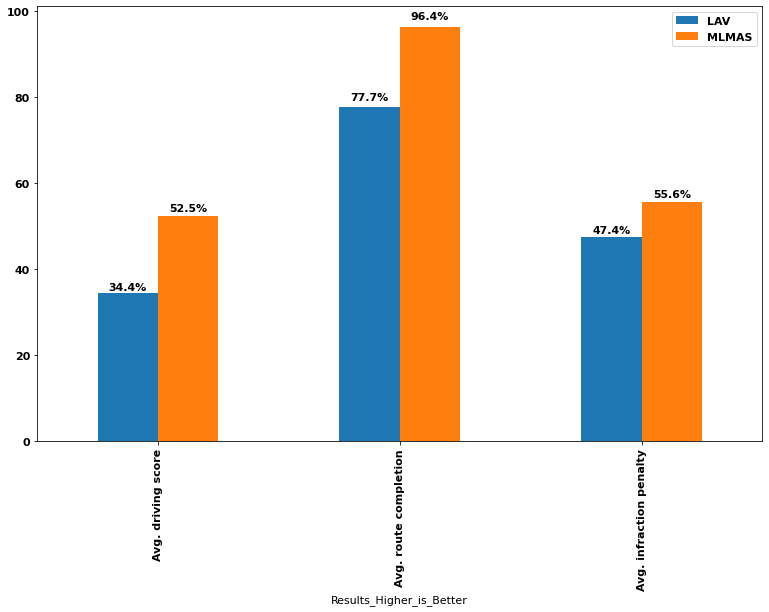

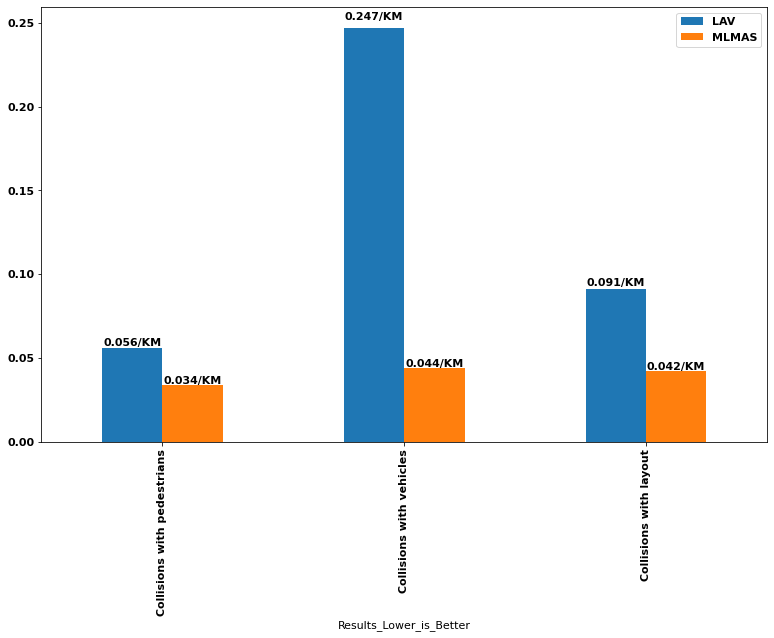

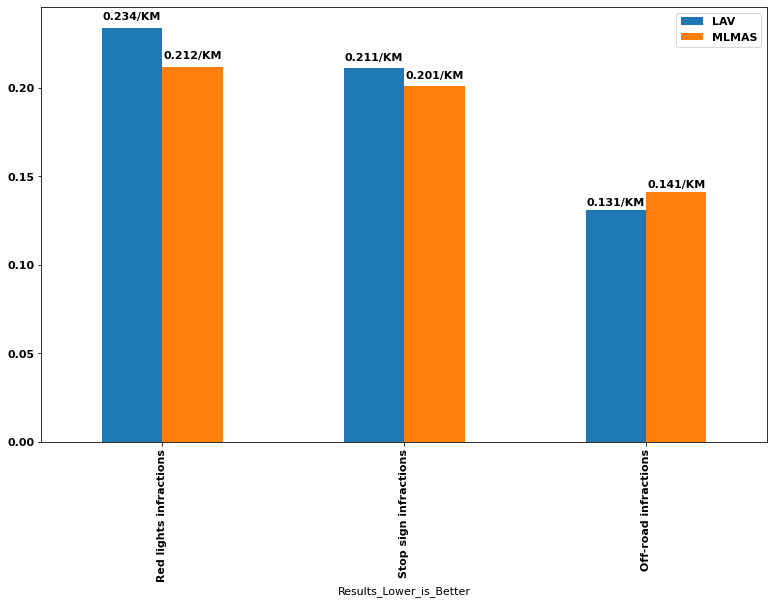

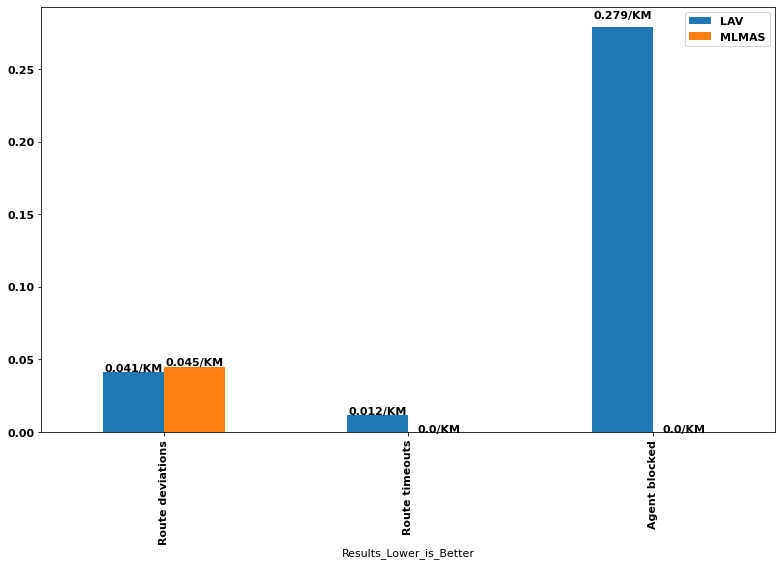

In [9]:
import matplotlib.pyplot as plt
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 11}

plt.rc('font', **font)


final_df_s, final_df_c, final_df_o, final_df_r = mergeTwoLeaderbordMetricsResults('LAV','MLMAS', lav_leaderboard_df ,mlmas_leaderboard_df)
graph = final_df_s.plot.bar(figsize=(13,8))

graph2 = final_df_c.plot.bar(figsize=(13,8))
graph3 = final_df_r.plot.bar(figsize=(13,8))
graph4 = final_df_o.plot.bar(figsize=(11,8))

plt.tight_layout()
show_values(graph)
show_values(graph2, pr="/KM")
show_values(graph3, pr="/KM")
show_values(graph4, pr="/KM")

## 3. Jason Agent Additional Metrics

In [10]:
jason_metrics_csv = pd.read_csv(mlmas_additional_metrics_file, delimiter=';')

final_columns = jason_metrics_csv.columns.values
final_columns[6], final_columns[7] = final_columns[7], final_columns[6]

jason_metrics_csv = jason_metrics_csv[final_columns]
additional_metrics_columns = ["Total Frames", 
                              "Front \nCollision Avoidance",
                             "Far Crossing \nCollision Avoidance",
                             "Close Crossing \nCollision Avoidance",
                             "Back \nCollision Avoidance",
                             "Traffic Light \nGreen [Go]",
                             "Traffic Light \nSlowdown",
                             "Blockage \ninterference"]
jason_metrics_csv.columns = additional_metrics_columns

print("== The additional Jason Agent metrics in each scenario")
jason_metrics_csv

== The additional Jason Agent metrics in each scenario


,Total Frames,Front \nCollision Avoidance,Far Crossing \nCollision Avoidance,Close Crossing \nCollision Avoidance,Back \nCollision Avoidance,Traffic Light \nGreen [Go],Traffic Light \nSlowdown,Blockage \ninterference
0,8316,0.008,0.011,0.055,0.026,0.004,0.000,0.003
1,10494,0.017,0.007,0.040,0.036,0.005,0.000,0.003
2,6346,0.003,0.005,0.022,0.006,0.005,0.000,0.004
3,7014,0.004,0.004,0.031,0.016,0.003,0.000,0.002
4,4351,0.000,0.025,0.046,0.023,0.003,0.000,0.002
5,4829,0.001,0.011,0.033,0.000,0.020,0.000,0.002
6,13632,0.009,0.004,0.031,0.022,0.002,0.000,0.003
7,12284,0.013,0.006,0.024,0.029,0.006,0.000,0.002
8,7614,0.006,0.008,0.028,0.019,0.007,0.000,0.005
9,10626,0.008,0.006,0.041,0.061,0.007,0.000,0.004


## Summary of the additional metrics

In [11]:
jason_metrics_csv.describe()

,Total Frames,Front \nCollision Avoidance,Far Crossing \nCollision Avoidance,Close Crossing \nCollision Avoidance,Back \nCollision Avoidance,Traffic Light \nGreen [Go],Traffic Light \nSlowdown,Blockage \ninterference
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.00000,36.000000
mean,11361.916667,0.006944,0.006861,0.023500,0.016306,0.006694,0.01725,0.002500
std,4645.471013,0.006042,0.004987,0.016782,0.019117,0.004458,0.02695,0.001082
min,2612.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.001000
25%,7794.750000,0.003750,0.004000,0.009000,0.003000,0.004750,0.00000,0.002000
50%,11031.500000,0.006000,0.006000,0.022000,0.011500,0.006000,0.00000,0.002000
75%,13764.750000,0.008000,0.009250,0.033250,0.021250,0.007250,0.02850,0.003000
max,20181.000000,0.030000,0.025000,0.071000,0.087000,0.020000,0.10400,0.005000


Total Average Agent Interferance Percentage: (8.1%)


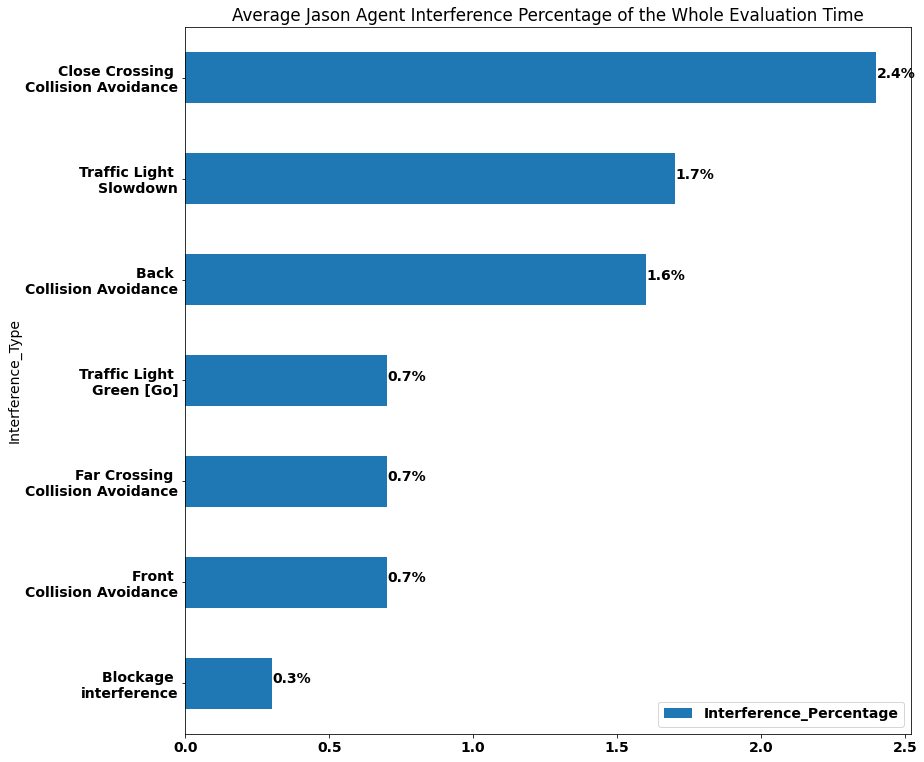

In [12]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)

mean_percentage = round(jason_metrics_csv.describe()*100,1)
mean_percentage = mean_percentage[additional_metrics_columns[1:]][1:2].values[0]
final_df_s = pd.DataFrame({'Interference_Percentage': mean_percentage
                  , 'Interference_Type': additional_metrics_columns[1:]}) 

final_df_s.index = final_df_s.Interference_Type
final_df_s = final_df_s.sort_values(by=["Interference_Percentage"])
graph = final_df_s.plot.barh(figsize=(13,13))
graph.set_title("Average Jason Agent Interference Percentage of the Whole Evaluation Time")
show_values(graph, is_vertical= False)

print("Total Average Agent Interferance Percentage: (%.1f%s)"%(mean_percentage.sum(),"%"))

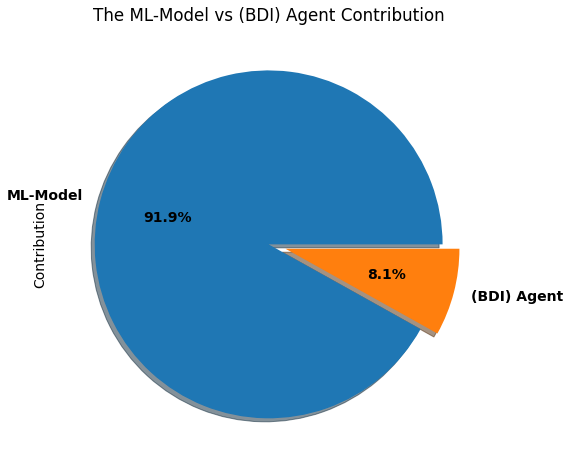

In [14]:

total_df = pd.DataFrame({"Models":["ML-Model","(BDI) Agent"], "Contribution": [100 - mean_percentage.sum(), mean_percentage.sum()]})
total_df.index = total_df.Models

plot = total_df.plot.pie(y='Contribution', title="The ML-Model vs (BDI) Agent Contribution", legend=False, \
                   autopct='%1.1f%%', explode=(0, 0.1), \
                   shadow=True, startangle=0,figsize=(8, 8))


### Just to insight on the extra evaluation time that MLMAS will take compared to the Model only

In [13]:
mlmas_duration = geEvaluationRecords(mlmas_leaderboard_jsn)
lav_duration = geEvaluationRecords(lav_leaderboard_jsn)

mlmas_avg_sec =  mlmas_duration.system_duration.sum()/mlmas_duration.game_duration.sum()
lav_avg_sec =  lav_duration.system_duration.sum()/lav_duration.game_duration.sum()

print("MLMAS takes (", round(mlmas_avg_sec,1) , "sec ) for each system second")
print("LAV only takes (", round(lav_avg_sec,1) , "sec ) for each system second")

MLMAS takes ( 11.5 sec ) for each system second
LAV only takes ( 6.9 sec ) for each system second


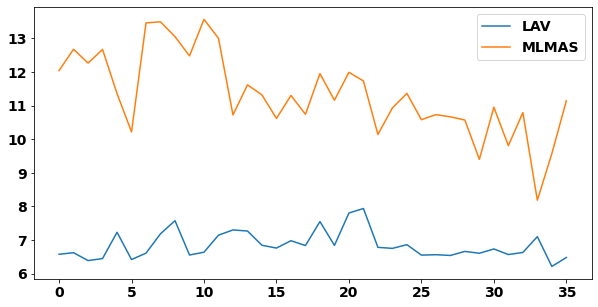

In [22]:
final_eval_df = pd.DataFrame({"LAV": lav_duration.system_duration.values/lav_duration.game_duration.values,
                             "MLMAS": mlmas_duration.system_duration.values/mlmas_duration.game_duration.values})

final_eval_df.plot(figsize=(10,5))